In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RHIFnF0r4iFkp0hGC8iZ")
project = rf.workspace("computervision-l27r0").project("kematangan-pisang-rqjh0")
version = project.version(2)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to kematangan-pisang-2 in folder:: 100%|██████████| 7864/7864 [00:00<00:00, 11972.48it/s]


In [2]:
import os
extract_path = '/content/kematangan-pisang-2'
os.listdir(extract_path)

['train', 'valid', 'README.dataset.txt', 'README.roboflow.txt', 'test']

In [ ]:
# Load images data

import os
import tensorflow as tf

train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'valid')
test_dir = os.path.join(extract_path, 'test')

# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

Found 6458 files belonging to 6 classes.
Found 461 files belonging to 6 classes.
Found 922 files belonging to 6 classes.


In [ ]:
train_class=train_ds.class_names
test_class=test_ds.class_names
val_class=val_ds.class_names

print("Train classes:", train_class)
print("test classes:", test_class)
print("val classes:", val_class)

Train classes: ['0', '1', '3', '5', '7', '9']
test classes: ['0', '1', '3', '5', '7', '9']
val classes: ['0', '1', '3', '5', '7', '9']


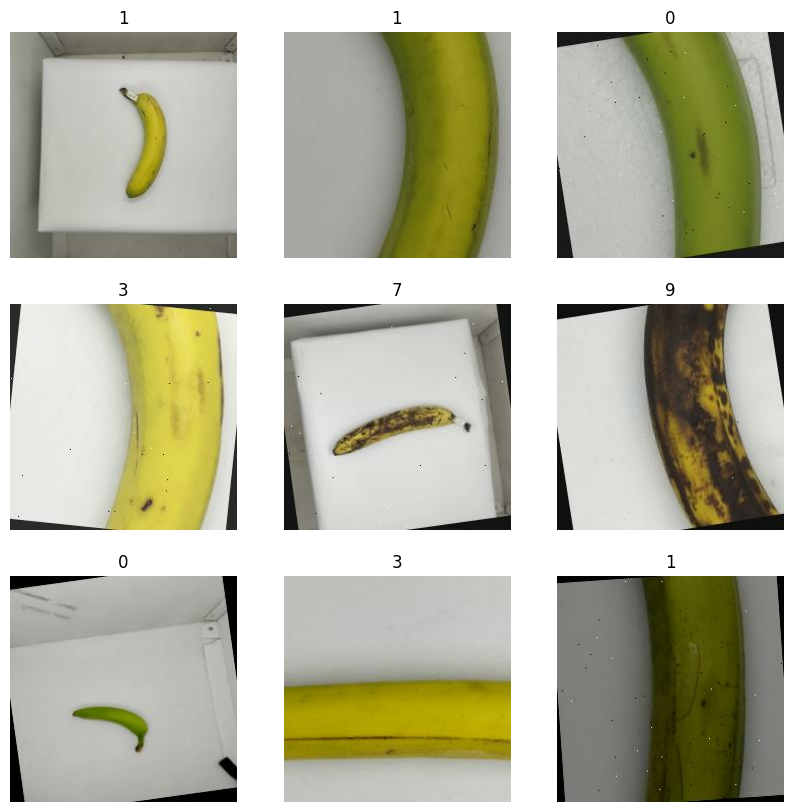

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import keras
from keras import layers
from tensorflow import keras

IMAGE_SIZE = (224,224)

# Model architecture
base_model = MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet', pooling='avg')

# Freeze base model
base_model.trainable = False

# Input layer with rescaling
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)

x = base_model(x)

# Add additional layers
x = layers.Dense(64, activation='relu')(x)
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

output = layers.Dense(6, activation='softmax', name="pred")(x)

# Construct model
model = Model(inputs=inputs, outputs=output, name="MobileNet")
# High learning rate
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
metric = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metric)

model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,370 (8.93 MB)

 Trainable params: 82,380 (321.80 KB)

 Non-trainable params: 2,257,990 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Train top layer

# Early stop when model doesnt improve after x epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when model doesnt improve after x epoch by factor of y with min lr z
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 32s 56ms/step - loss: 1.0582 - sparse_categorical_accuracy: 0.6068 - val_loss: 0.4792 - val_sparse_categorical_accuracy: 0.7972 - learning_rate: 0.0100
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 0.6207 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.4273 - val_sparse_categorical_accuracy: 0.8254 - learning_rate: 0.0100
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.3324 - val_sparse_categorical_accuracy: 0.8796 - learning_rate: 0.0100
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.5297 - sparse_categorical_accuracy: 0.7800 - val_loss: 0.2843 - val_sparse_categorical_accuracy: 0.9078 - learning_rate: 0.0100
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - loss: 0.4803 - sparse_categorical_accuracy: 0.7898 - val_loss: 0.2290 - val_sparse_categorical_accuracy: 0.9187 - learning_rate: 0.0100
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 

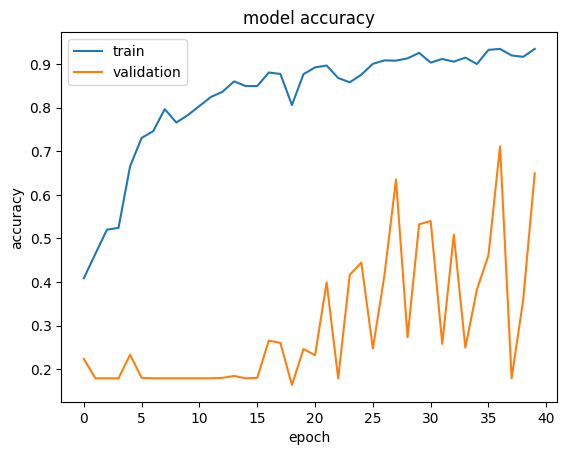

In [ ]:
plot_hist(history)

In [ ]:
# Unfreeze base model

# Unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Low learning rate
optimizer=tf.keras.optimizers.Adam(1e-5)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=metric
)

hist_fine_tune = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 117ms/step - loss: 2.9834 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.4055 - val_sparse_categorical_accuracy: 0.8655 - learning_rate: 1.0000e-05
Epoch 2/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.7157 - val_loss: 0.3855 - val_sparse_categorical_accuracy: 0.8698 - learning_rate: 1.0000e-05
Epoch 3/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.3259 - val_sparse_categorical_accuracy: 0.8861 - learning_rate: 1.0000e-05
Epoch 4/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - loss: 0.5493 - sparse_categorical_accuracy: 0.7802 - val_loss: 0.3008 - val_sparse_categorical_accuracy: 0.8926 - learning_rate: 1.0000e-05
Epoch 5/40
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - loss: 0.4956 - sparse_categorical_accuracy: 0.7983 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9013 - learning_rate: 1.0000e-05
Epoch 6/40
404/404 

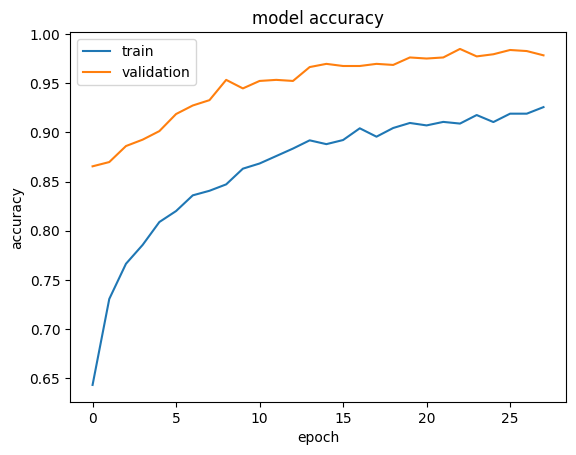

In [ ]:
plot_hist(hist_fine_tune)

In [ ]:
# Evaluate model

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0541 - sparse_categorical_accuracy: 0.9806
Test Accuracy: 98.26%


Found 461 files belonging to 6 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Class names: ['0', '1', '3', '5', '7', '9']
Number of test samples: 461
Label distribution: [ 62  91 103  58  64  83]


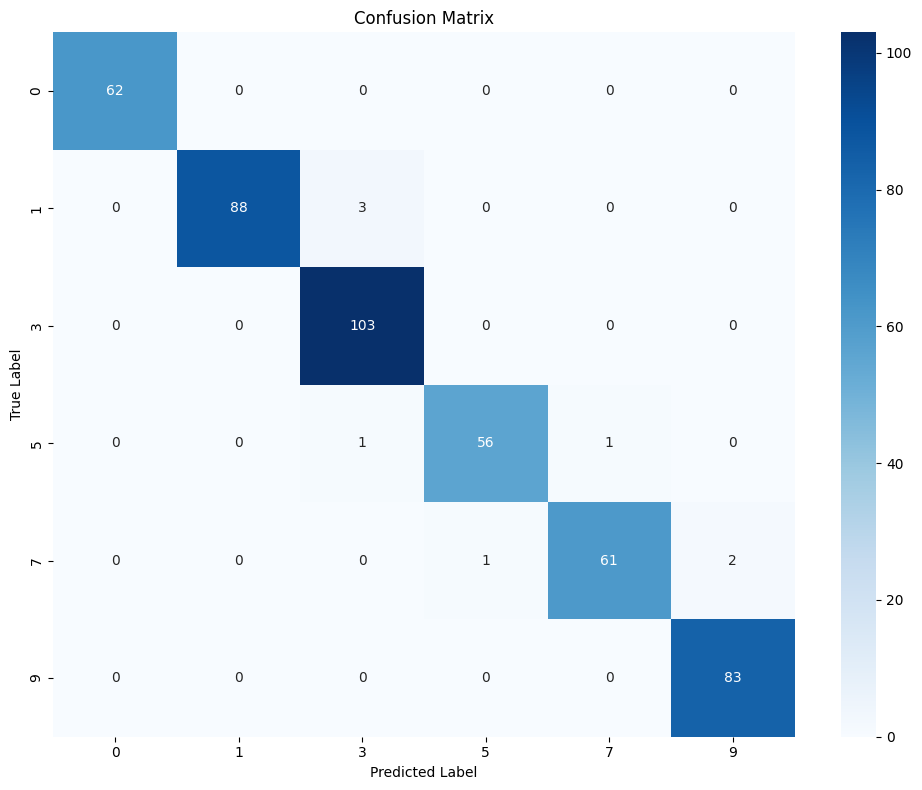


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      0.97      0.98        91
           3       0.96      1.00      0.98       103
           5       0.98      0.97      0.97        58
           7       0.98      0.95      0.97        64
           9       0.98      1.00      0.99        83

    accuracy                           0.98       461
   macro avg       0.98      0.98      0.98       461
weighted avg       0.98      0.98      0.98       461


Overall Accuracy: 0.9826

Per-class Accuracy:
0: 1.0000
1: 0.9670
3: 1.0000
5: 0.9655
7: 0.9531
9: 1.0000


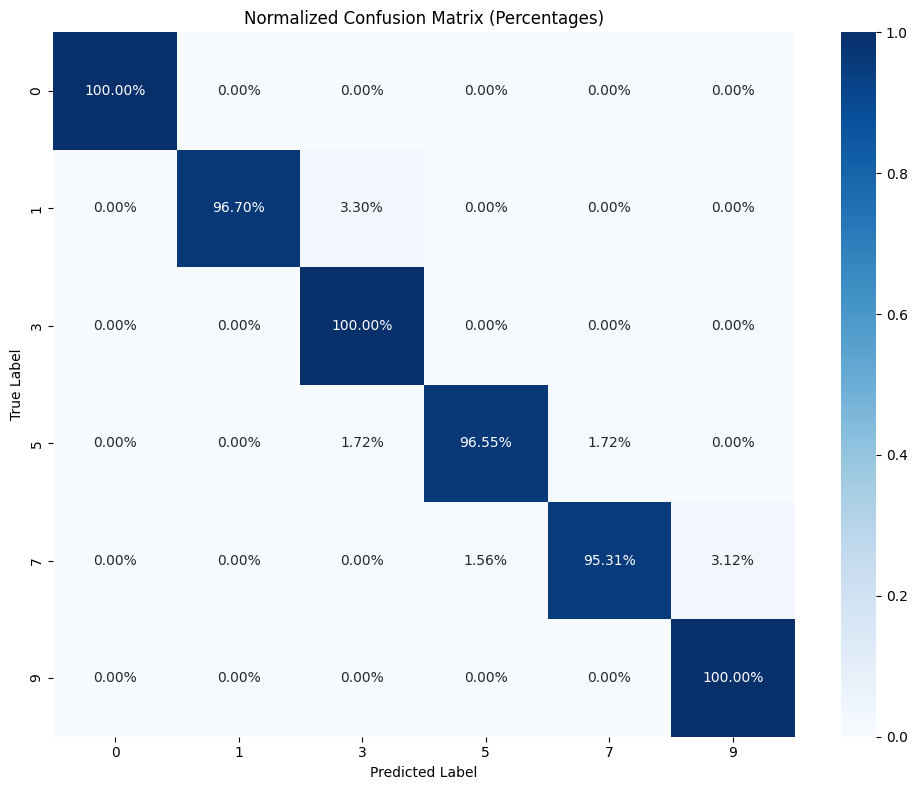

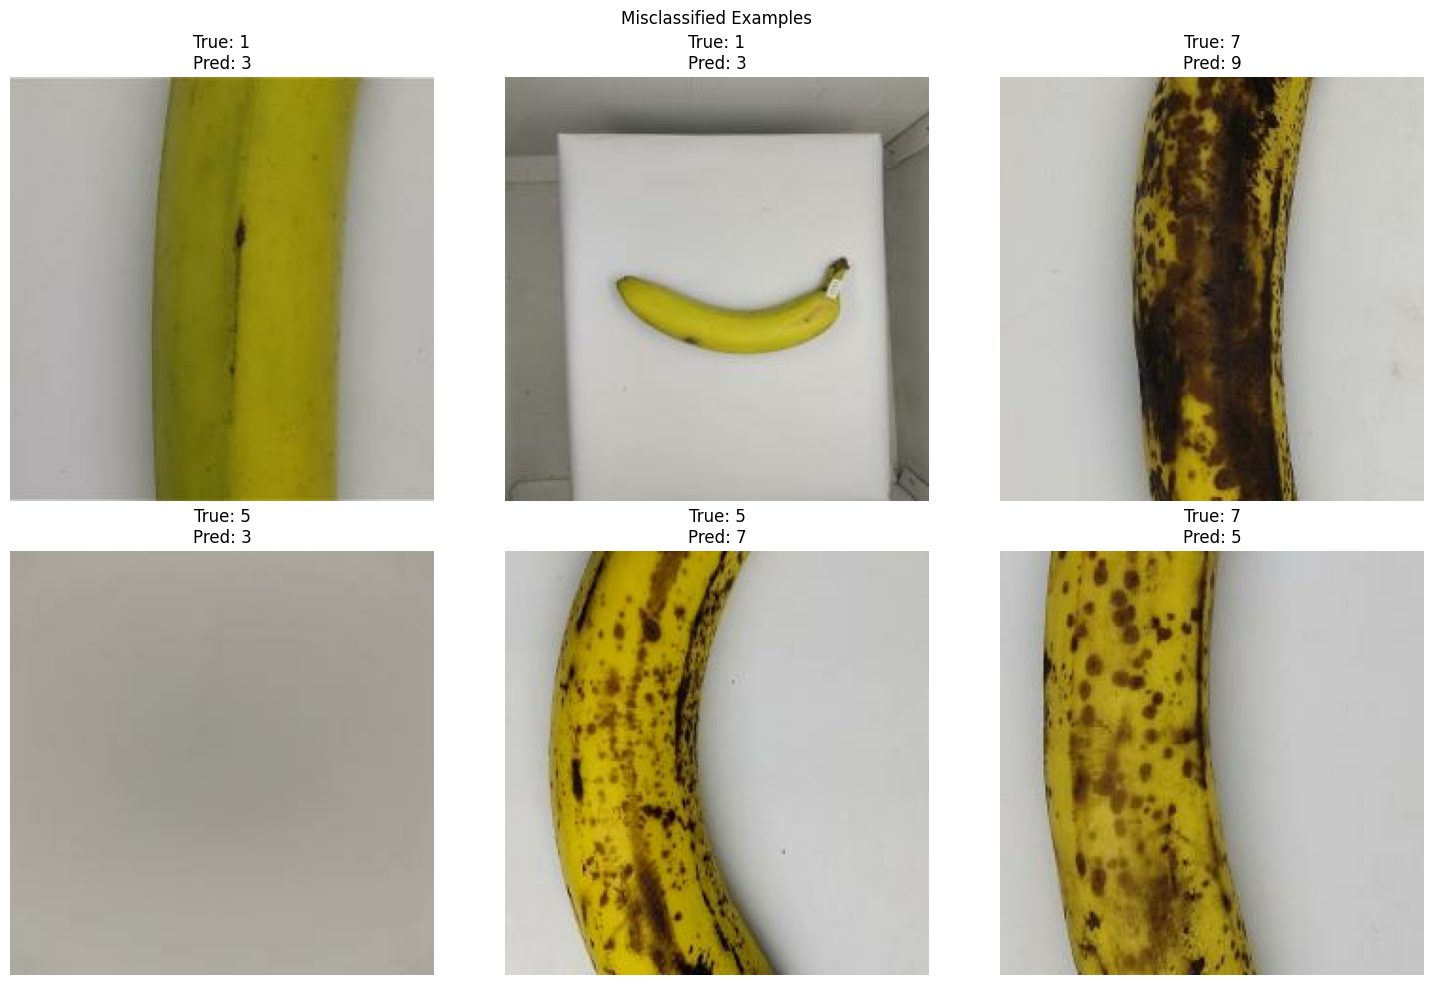

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Create test dataset without shuffling for consistent label order
test_ds_no_shuffle = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Important: no shuffling
    seed=123
)

# Get predictions on test dataset
y_pred = model.predict(test_ds_no_shuffle)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test dataset
y_true = []
for images, labels in test_ds_no_shuffle:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Get class names from the dataset
class_names = test_ds_no_shuffle.class_names
print("Class names:", class_names)
print(f"Number of test samples: {len(y_true)}")
print(f"Label distribution: {np.bincount(y_true)}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Calculate and display accuracy metrics
accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = np.sum((y_pred_classes == i) & (y_true == i)) / np.sum(y_true == i)
    print(f"{class_name}: {class_accuracy:.4f}")

# Normalized confusion matrix (percentages)
plt.figure(figsize=(10, 8))
cm_normalized = confusion_matrix(y_true, y_pred_classes, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display some misclassified examples (optional)
def show_misclassified_examples(num_examples=6):
    """Display examples of misclassified images"""
    misclassified_indices = np.where(y_pred_classes != y_true)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return

    # Get a subset of misclassified examples
    selected_indices = np.random.choice(misclassified_indices,
                                      min(num_examples, len(misclassified_indices)),
                                      replace=False)

    # Get images from test dataset (no shuffle)
    images_list = []
    for images, labels in test_ds_no_shuffle:
        images_list.extend(images.numpy())

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images_list[idx].astype(np.uint8))
        plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}')
        plt.axis('off')

    plt.suptitle('Misclassified Examples')
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_examples()

## EPOCHS = 20

In [3]:
# Load images data

import os
import tensorflow as tf

train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'valid')
test_dir = os.path.join(extract_path, 'test')

# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=123
)

Found 6458 files belonging to 6 classes.
Found 461 files belonging to 6 classes.
Found 922 files belonging to 6 classes.


In [4]:
train_class=train_ds.class_names
test_class=test_ds.class_names
val_class=val_ds.class_names

print("Train classes:", train_class)
print("test classes:", test_class)
print("val classes:", val_class)

Train classes: ['0', '1', '3', '5', '7', '9']
test classes: ['0', '1', '3', '5', '7', '9']
val classes: ['0', '1', '3', '5', '7', '9']


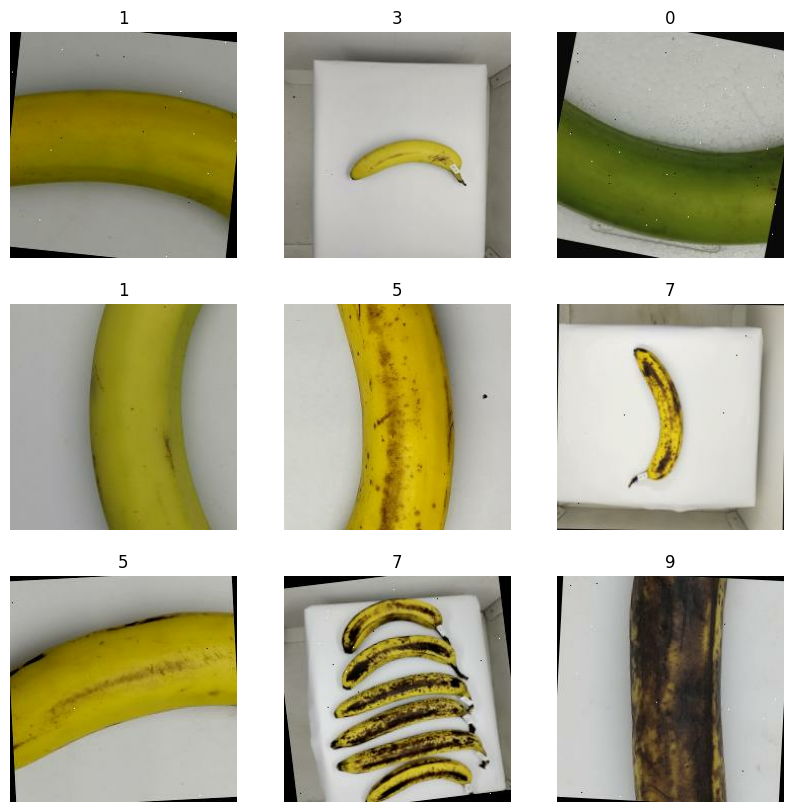

In [5]:
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class[labels[i]])
    plt.axis("off")

In [6]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 224, 224, 3)
(16,)


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
import keras
from keras import layers
from tensorflow import keras

IMAGE_SIZE = (224,224)

# Model architecture
base_model = MobileNetV2(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), include_top=False, weights='imagenet', pooling='avg')

# Freeze base model
base_model.trainable = False

# Input layer with rescaling
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.BatchNormalization()(x)

x = base_model(x)

# Add additional layers
x = layers.Dense(64, activation='relu')(x)
top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

output = layers.Dense(6, activation='softmax', name="pred")(x)

# Construct model
model = Model(inputs=inputs, outputs=output, name="MobileNet")
# High learning rate
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
metric = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metric)

model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,370 (8.93 MB)

 Trainable params: 82,380 (321.80 KB)

 Non-trainable params: 2,257,990 (8.61 MB)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# # Train top layer

# # Early stop when model doesnt improve after x epoch
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Reduce learning rate when model doesnt improve after x epoch by factor of y with min lr z
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# history = model.fit(
#     train_ds,
#     epochs=10,
#     validation_data=val_ds,
#     callbacks=[early_stopping, reduce_lr]
# )

In [ ]:
# plot_hist(history)

In [8]:
# Unfreeze base model

# Unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Low learning rate
optimizer=tf.keras.optimizers.Adam(1e-5)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=metric
)

hist_fine_tune = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 102s 134ms/step - loss: 1.5148 - sparse_categorical_accuracy: 0.3937 - val_loss: 1.1493 - val_sparse_categorical_accuracy: 0.5716
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - loss: 0.6538 - sparse_categorical_accuracy: 0.7838 - val_loss: 0.6700 - val_sparse_categorical_accuracy: 0.7430
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.4364 - sparse_categorical_accuracy: 0.8474 - val_loss: 0.3865 - val_sparse_categorical_accuracy: 0.8601
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - loss: 0.3381 - sparse_categorical_accuracy: 0.8828 - val_loss: 0.2854 - val_sparse_categorical_accuracy: 0.8937
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - loss: 0.2817 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.2116 - val_sparse_categorical_accuracy: 0.9230
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.2416 - sparse_categorical_accuracy: 0.9113 - val_loss: 0.1562 - val_sparse_categorical_accurac

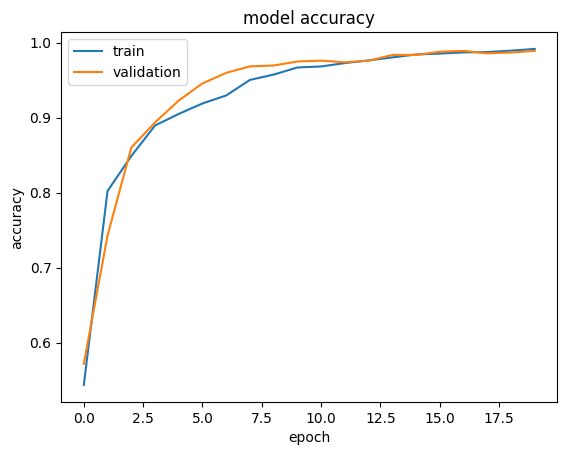

In [9]:
plot_hist(hist_fine_tune)

In [10]:
# Evaluate model

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.9822
Test Accuracy: 98.48%


Found 461 files belonging to 6 classes.
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step
Class names: ['0', '1', '3', '5', '7', '9']
Number of test samples: 461
Label distribution: [ 62  91 103  58  64  83]


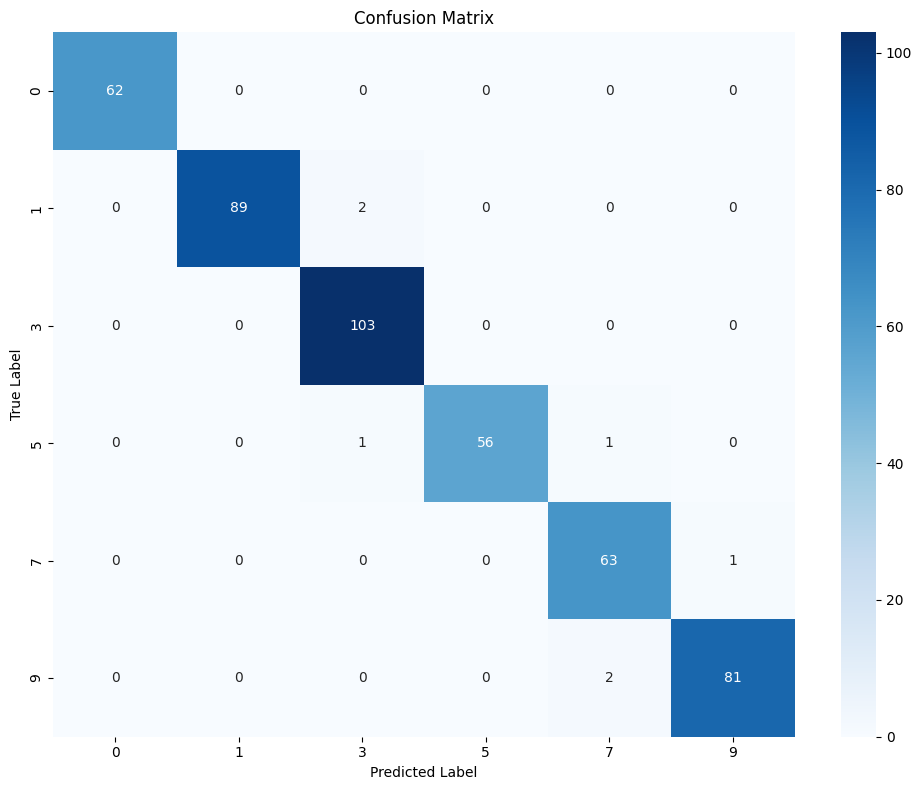


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      0.98      0.99        91
           3       0.97      1.00      0.99       103
           5       1.00      0.97      0.98        58
           7       0.95      0.98      0.97        64
           9       0.99      0.98      0.98        83

    accuracy                           0.98       461
   macro avg       0.99      0.98      0.98       461
weighted avg       0.99      0.98      0.98       461


Overall Accuracy: 0.9848

Per-class Accuracy:
0: 1.0000
1: 0.9780
3: 1.0000
5: 0.9655
7: 0.9844
9: 0.9759


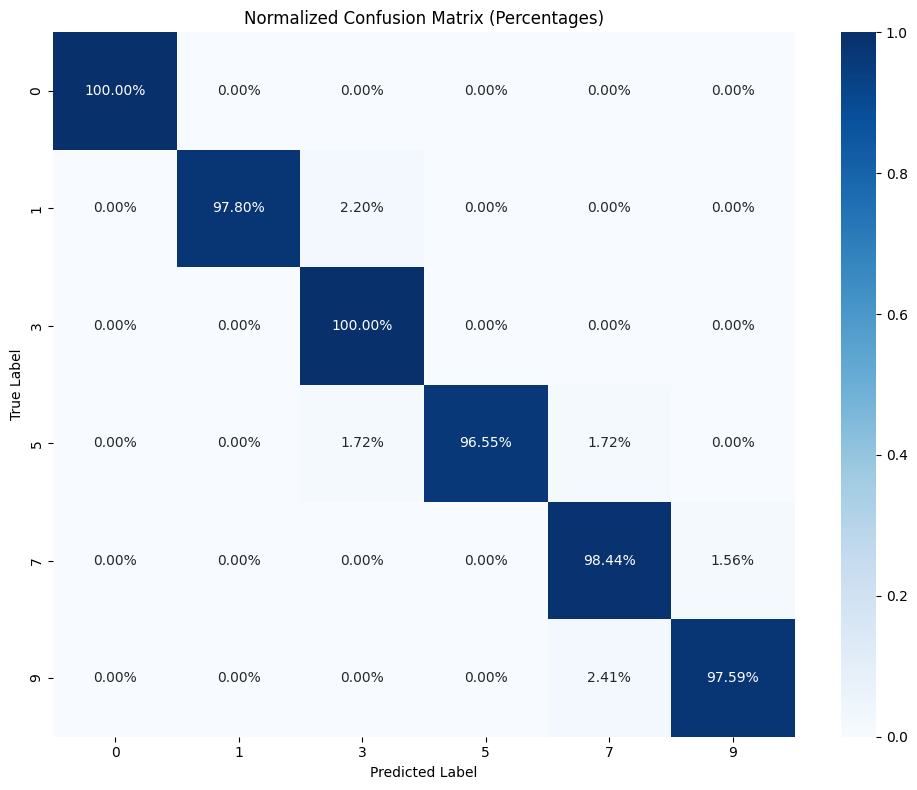

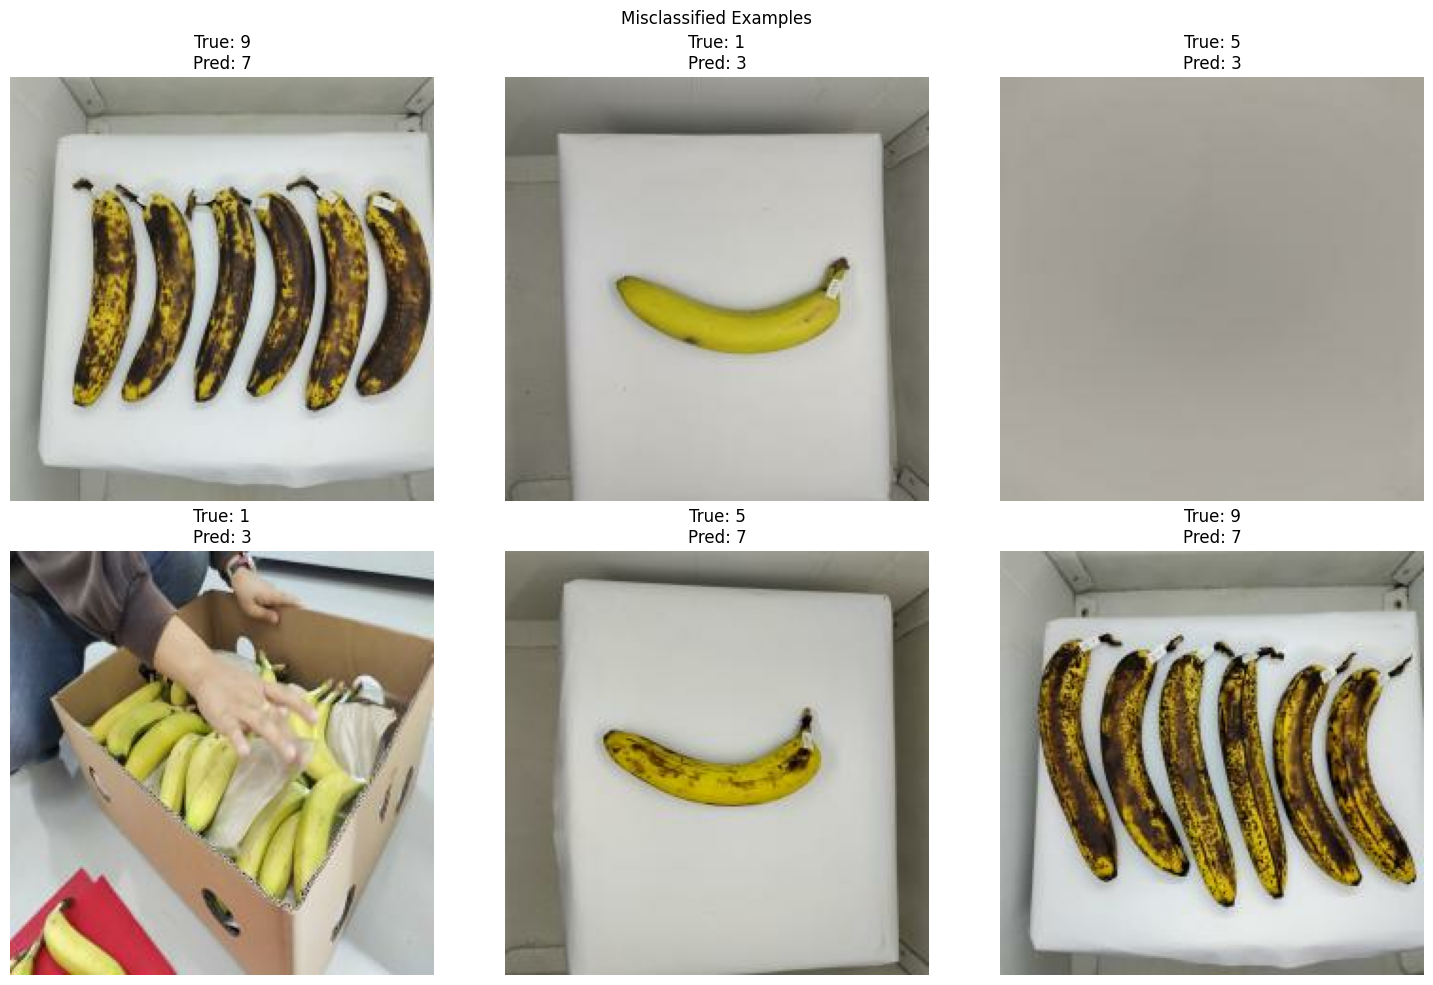

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Create test dataset without shuffling for consistent label order
test_ds_no_shuffle = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Important: no shuffling
    seed=123
)

# Get predictions on test dataset
y_pred = model.predict(test_ds_no_shuffle)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test dataset
y_true = []
for images, labels in test_ds_no_shuffle:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)

# Get class names from the dataset
class_names = test_ds_no_shuffle.class_names
print("Class names:", class_names)
print(f"Number of test samples: {len(y_true)}")
print(f"Label distribution: {np.bincount(y_true)}")

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Calculate and display accuracy metrics
accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Per-class accuracy
print("\nPer-class Accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = np.sum((y_pred_classes == i) & (y_true == i)) / np.sum(y_true == i)
    print(f"{class_name}: {class_accuracy:.4f}")

# Normalized confusion matrix
plt.figure(figsize=(10, 8))
cm_normalized = confusion_matrix(y_true, y_pred_classes, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Display some misclassified examples
def show_misclassified_examples(num_examples=6):
    """Display examples of misclassified images"""
    misclassified_indices = np.where(y_pred_classes != y_true)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return

    # Get a subset of misclassified
    selected_indices = np.random.choice(misclassified_indices,
                                      min(num_examples, len(misclassified_indices)),
                                      replace=False)

    # Get images from test dataset (no shuffle)
    images_list = []
    for images, labels in test_ds_no_shuffle:
        images_list.extend(images.numpy())

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images_list[idx].astype(np.uint8))
        plt.title(f'True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}')
        plt.axis('off')

    plt.suptitle('Misclassified Examples')
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_examples()